# Problem Description
In this problem, you will forecast the outcome of a portfolio of loans. Each loan is scheduled to be repaid over 3 years and is structured as follows:

#### Dataset
Each row corresponds to a loan, and the columns are defined as follows:

- The column with header `days since origination` indicates the number of days that elapsed between origination and the date when the data was collected.
- For loans that charged off before the data was collected, the column with header `days from origination to chargeoff` indicates the number of days that elapsed between origination and chargeoff.

#### Goal
We would like you to estimate **what fraction of these loans will have charged off by the time all of their 3-year terms are finished**.


Reference: https://rstudio-pubs-static.s3.amazonaws.com/203258_d20c1a34bc094151a0a1e4f4180c5f6f.html#feature-engineering

https://github.com/hlncrg/upStartDataChallenge/blob/master/upstartDataChallenge.ipynb

# Exploratory Data Analysis
#### Load libraries & Read data

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit

In [13]:
data = pd.read_csv('loan_timing.csv', header = 0)

Now I created a new column called "chargeoff" which is a dummy variable, where 1 means that loan has charged off and 0 otherwise. This can be used as the response variable if we want to build a model later.

In [17]:
data['chargeoff'] = np.where(data['days from origination to chargeoff'] >= 0, 1, 0)

Now let's look at part of the dataset.

In [21]:
data[11:16]

,days since origination,days from origination to chargeoff,chargeoff
11,336,NaN,0
12,51,NaN,0
13,117,NaN,0
14,327,78.0,1
15,400,390.0,1


#### What percentage of loans have been charged off when the data was collected?
We can tell that 3305 out of 50000 loans have been charged off, which is about 6.7%.

In [24]:
float(data[data["chargeoff"] == 1].shape[0])/ float(data.shape[0])

0.0661

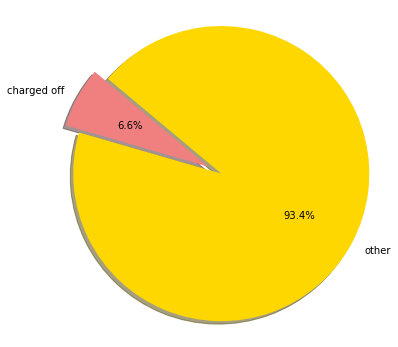

In [38]:
# pie chart
fig, ax = plt.subplots(figsize = (6, 6))
labels = "charged off", "other"
sizes = [3305, 50000 - 3305]
colors = ['lightcoral', 'gold']
explode = (0.1, 0) # explode chargedoff

plt.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = '%1.1f%%', shadow = True, startangle = 140)
plt.axis('equal')
plt.show()

#### Among 3305 charged off loans, what is the relationship between the `days since origination` and `days from origination to chargeoff`?

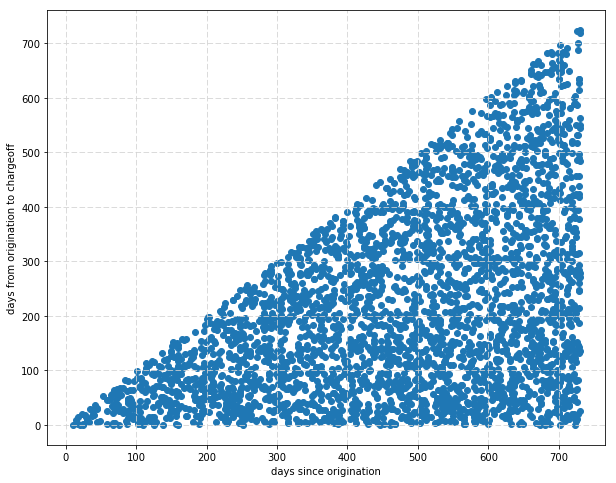

In [35]:
fig, ax = plt.subplots(figsize = (10, 8))
x = data[data["chargeoff"] == 1]['days since origination']
y = data[data["chargeoff"] == 1]["days from origination to chargeoff"]
plt.scatter(x, y)

plt.xlabel('days since origination')
plt.ylabel('days from origination to chargeoff')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

I don't see a significant relationship through the scatter plot.

In [33]:
np.array(x)

array([327, 400, 721, ..., 356, 280, 487])

In [36]:
float(data[data["chargeoff"] == 1].shape[0])

3305.0